In [1]:
import numpy as np
import pandas as pd
import math as m
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
import pickle
import sklearn
print(sklearn.__version__)

0.22.1


## H-D Parameters

In [2]:
# These are the h-d parameters from Universal Robots for the UR10.
UR10_HD_parameters = list([["Joint_0",  0.0,    0.0, 0.1273,   np.pi/2],
                           ["Joint_1", -0.612,  0.0, 0.0,      0.0],
                           ["Joint_2", -0.5723, 0.0, 0.0,      0.0],
                           ["Joint_3",  0.0,    0.0, 0.163941, np.pi/2],
                           ["Joint_4",  0.0,    0.0, 0.1157,  -np.pi/2],
                           ["Joint_5",  0.0,    0.0, 0.0922,   0.0]])
hd_params = pd.DataFrame(UR10_HD_parameters, 
                         columns=["Joint", "a[m]", "theta[rad]", "d[m]", "alpha[rad]"])

display(hd_params)

,Joint,a[m],theta[rad],d[m],alpha[rad]
0,Joint_0,0.0000,0.0,0.127300,1.570796
1,Joint_1,-0.6120,0.0,0.000000,0.000000
2,Joint_2,-0.5723,0.0,0.000000,0.000000
3,Joint_3,0.0000,0.0,0.163941,1.570796
4,Joint_4,0.0000,0.0,0.115700,-1.570796
5,Joint_5,0.0000,0.0,0.092200,0.000000


#### import robot joint data 

In [3]:
data = pd.read_csv("/home/ur10pc/Desktop/robot_data2/80k_data/joints_data.csv")
display(data.head(10))

,joint_0,joint_1,joint_2,joint_3,joint_4,joint_5
0,1.404830,-1.171765,2.483047,-2.862827,-1.566874,2.720634
1,1.404794,-1.171765,2.483070,-2.862839,-1.566886,2.720623
2,1.404842,-1.171752,2.483034,-2.862851,-1.566910,2.720611
3,1.404818,-1.171752,2.483070,-2.862839,-1.566910,2.720634
4,1.404806,-1.171777,2.483058,-2.862863,-1.566886,2.720611
5,1.404782,-1.171777,2.483034,-2.862851,-1.566910,2.720623
6,1.404818,-1.171777,2.483082,-2.862863,-1.566898,2.720611
7,1.404842,-1.171765,2.483058,-2.862851,-1.566886,2.720611
8,1.404818,-1.171765,2.483070,-2.862815,-1.566886,2.720623
9,1.404830,-1.171789,2.483047,-2.862851,-1.566922,2.720646


## 'A' Matrix Method

In [4]:

Cart_data = []

class A_matrix_con:
    def __init__(self, a, theta, d, alpha):
        self.a = a
        self.theta = theta
        self.d = d
        self.alpha = alpha


    # An array that calculates the 'A' matrix of each joint.
    def A_matrix(self):
        return pd.DataFrame([[np.cos(self.theta),  -np.sin(self.theta)*np.cos(self.alpha),  np.sin(self.theta)*np.sin(self.alpha), self.a*np.cos(self.theta)],
                             [np.sin(self.theta),   np.cos(self.theta)*np.cos(self.alpha), -np.cos(self.theta)*np.sin(self.alpha), self.a*np.sin(self.theta)],
                             [0,                      np.sin(self.alpha),                       np.cos(self.alpha),                      self.d],
                             [0,                      0,                                          0,                                         1]])


## Convert each joint pose to a Cartesian position.
for index, row in data.iterrows():

    theta_0 = row["joint_0"] ## joint angle of joint_0 on row 
    theta_1 = row["joint_1"] 
    theta_2 = row["joint_2"]
    theta_3 = row["joint_3"] 
    theta_4 = row["joint_4"] 
    theta_5 = row["joint_5"]
    
    # The six joints and their d-h parameters as per the hd_params table
    ## This create a 4*4 matrix for each joint
    joint_0 = A_matrix_con(hd_params["a[m]"][0], theta_0, hd_params["d[m]"][0], hd_params["alpha[rad]"][0])
    joint_1 = A_matrix_con(hd_params["a[m]"][1], theta_1, hd_params["d[m]"][1], hd_params["alpha[rad]"][1])
    joint_2 = A_matrix_con(hd_params["a[m]"][2], theta_2, hd_params["d[m]"][2], hd_params["alpha[rad]"][2])
    joint_3 = A_matrix_con(hd_params["a[m]"][3], theta_3, hd_params["d[m]"][3], hd_params["alpha[rad]"][3])
    joint_4 = A_matrix_con(hd_params["a[m]"][4], theta_4, hd_params["d[m]"][4], hd_params["alpha[rad]"][4])
    joint_5 = A_matrix_con(hd_params["a[m]"][5], theta_5, hd_params["d[m]"][5], hd_params["alpha[rad]"][5])

    
    # Instances of the 'A' matrix for each joint.
    ## 
    A_0 = (joint_0.A_matrix())
    A_1 = (joint_1.A_matrix())
    A_2 = (joint_2.A_matrix())
    A_3 = (joint_3.A_matrix())
    A_4 = (joint_4.A_matrix())
    A_5 = (joint_5.A_matrix())

    # Translation Vector 
    ## This was originally only the T vector, but is now the T and R matrix. 
    T = A_0 @ A_1 @ A_2 @ A_3 @ A_4 @ A_5  ## __matmul__ 
    
    new_data = [T[3][0], T[3][1], T[3][2], ## x, y, z
               m.atan2(T[2][1],T[2][2]),   ## roll
               m.atan2((-T[2][0]), (m.sqrt((T[2][1])**2)+((T[2][2])**2))), ## pitch
               m.atan2(T[1][0], T[0][0])]  ## yaw
    
    Cart_data.append(new_data)
    
    
Cart_data = pd.DataFrame(Cart_data, columns=["x", "y", "z", "Rx", "Ry", "Rz"])
display(Cart_data.head(50))
#Cart_data.to_csv("/home/ur10pc/Desktop/robot_data2/80k_data/cart_data.csv", index=False)



,x,y,z,Rx,Ry,Rz
0,0.079684,-0.518834,0.043674,3.123254,-0.006924,0.255019
1,0.079666,-0.518822,0.043669,3.123240,-0.006915,0.254995
2,0.079685,-0.518841,0.043674,3.123272,-0.006885,0.255054
3,0.079676,-0.518819,0.043663,3.123224,-0.006893,0.255007
4,0.079671,-0.518832,0.043681,3.123288,-0.006908,0.255019
5,0.079654,-0.518848,0.043686,3.123296,-0.006882,0.254983
6,0.079678,-0.518816,0.043675,3.123262,-0.006899,0.255031
7,0.079690,-0.518827,0.043674,3.123264,-0.006911,0.255054
8,0.079679,-0.518818,0.043666,3.123217,-0.006919,0.255019
9,0.079678,-0.518837,0.043689,3.123294,-0.006870,0.255007


In [5]:
print(len(Cart_data))

72000


In [6]:
Cart_data.to_csv("/home/ur10pc/Desktop/robot_data2/80k_data/cart_data_plus_rotation.csv", index=False)

In [7]:
force_data = pd.read_csv("/home/ur10pc/Desktop/robot_data2/80k_data/four_joints_and_six_force.csv") ##mean_force_data
cart_data = pd.read_csv("/home/ur10pc/Desktop/robot_data2/80k_data/cart_data_plus_rotation.csv")
                 

In [8]:
print(len(force_data))
print(len(cart_data))

72000
72000


In [9]:
display(force_data)

,Fx,Fy,Fz,Rx,Ry,Rz,joint_0,joint_2,joint_4,joint_5
0,0.000000,-0.030003,0.000000,0.004,0.002,-0.002,1.404830,2.483047,-1.566874,2.720634
1,-0.040001,-0.180000,-0.020000,-0.001,0.003,-0.002,1.404794,2.483070,-1.566886,2.720623
2,0.000000,-0.090000,-0.010002,0.001,0.002,-0.001,1.404842,2.483034,-1.566910,2.720611
3,0.009995,-0.100002,0.009998,0.001,0.002,-0.001,1.404818,2.483070,-1.566910,2.720634
4,-0.020004,0.049999,-0.010002,0.003,0.004,-0.004,1.404806,2.483058,-1.566886,2.720611
...,...,...,...,...,...,...,...,...,...,...
71995,0.279999,1.430000,0.950001,-0.087,0.042,-0.048,2.518909,1.282793,-1.569965,2.198264
71996,0.430000,1.899998,0.950001,-0.105,-0.002,-0.058,2.506789,1.305049,-1.569701,2.195798
71997,0.239998,1.750000,0.849998,-0.204,-0.089,-0.066,2.495376,1.327103,-1.569402,2.192206
71998,0.889999,1.009998,1.619999,-0.203,-0.056,-0.066,2.485090,1.349792,-1.568935,2.187465


In [10]:
force = force_data.iloc[:,:6]
force.columns = ['Fx', 'Fy', 'Fz','FRx', 'FRy', 'FRz']
display(force)

,Fx,Fy,Fz,FRx,FRy,FRz
0,0.000000,-0.030003,0.000000,0.004,0.002,-0.002
1,-0.040001,-0.180000,-0.020000,-0.001,0.003,-0.002
2,0.000000,-0.090000,-0.010002,0.001,0.002,-0.001
3,0.009995,-0.100002,0.009998,0.001,0.002,-0.001
4,-0.020004,0.049999,-0.010002,0.003,0.004,-0.004
...,...,...,...,...,...,...
71995,0.279999,1.430000,0.950001,-0.087,0.042,-0.048
71996,0.430000,1.899998,0.950001,-0.105,-0.002,-0.058
71997,0.239998,1.750000,0.849998,-0.204,-0.089,-0.066
71998,0.889999,1.009998,1.619999,-0.203,-0.056,-0.066


In [11]:
cart_force = pd.concat([cart_data, force], axis=1)
display(cart_force)
#cart_force.to_csv("/home/ur10pc/Desktop/robot_data2/80k_data/cart_6_force_features.csv", index=False)

,x,y,z,Rx,Ry,Rz,Fx,Fy,Fz,FRx,FRy,FRz
0,0.079684,-0.518834,0.043674,3.123254,-0.006924,0.255019,0.000000,-0.030003,0.000000,0.004,0.002,-0.002
1,0.079666,-0.518822,0.043669,3.123240,-0.006915,0.254995,-0.040001,-0.180000,-0.020000,-0.001,0.003,-0.002
2,0.079685,-0.518841,0.043674,3.123272,-0.006885,0.255054,0.000000,-0.090000,-0.010002,0.001,0.002,-0.001
3,0.079676,-0.518819,0.043663,3.123224,-0.006893,0.255007,0.009995,-0.100002,0.009998,0.001,0.002,-0.001
4,0.079671,-0.518832,0.043681,3.123288,-0.006908,0.255019,-0.020004,0.049999,-0.010002,0.003,0.004,-0.004
...,...,...,...,...,...,...,...,...,...,...,...,...
71995,0.962274,-0.488970,0.078839,-3.124425,-0.024918,1.891236,0.279999,1.430000,0.950001,-0.087,0.042,-0.048
71996,0.949895,-0.495865,0.078113,-3.124560,-0.024563,1.881592,0.430000,1.899998,0.950001,-0.105,-0.002,-0.058
71997,0.937796,-0.501828,0.077442,-3.124877,-0.024083,1.873783,0.239998,1.750000,0.849998,-0.204,-0.089,-0.066
71998,0.925992,-0.506313,0.076703,-3.125365,-0.023734,1.868253,0.889999,1.009998,1.619999,-0.203,-0.056,-0.066


### Cartesian Correlation:

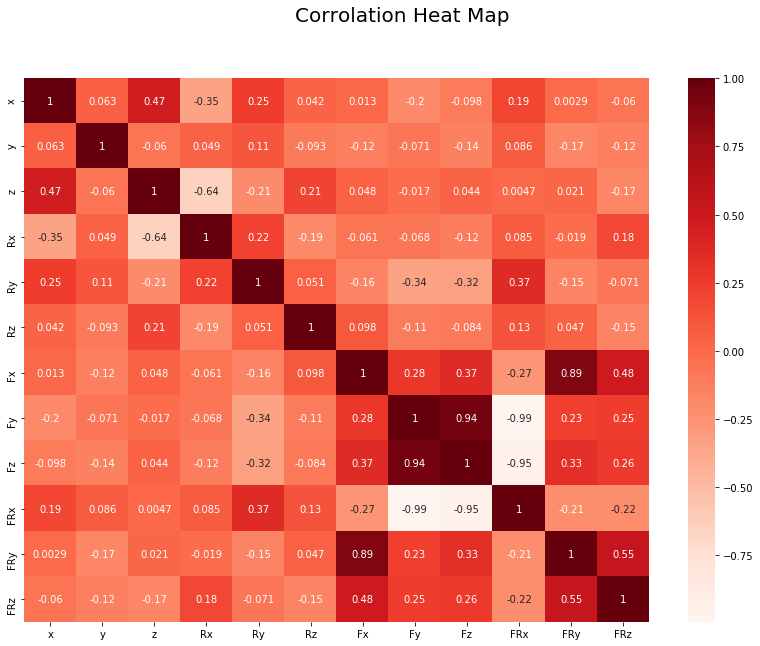

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

plt.figure(figsize=(14,10))
x = cart_force

cor = x.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

plt.suptitle('Corrolation Heat Map', fontsize=20)

plt.show()

### Joint Corrolation:

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

plt.figure(figsize=(14,10))
x = joints_data 

cor = x.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

plt.suptitle('Corrolation Heat Map', fontsize=20)

plt.show()

NameError: name 'joints_data' is not defined

<Figure size 1008x720 with 0 Axes>

In [14]:
joint_force_data = pd.read_csv("/home/ur10pc/Desktop/robot_data2/80k_data/joints_and_force.csv")

display(mean_force_data.head())
#print(len(mean_force_data))
print(len(joints_data))
print(len(cart_data))

NameError: name 'mean_force_data' is not defined

In [ ]:
joints_to_cart = pd.concat([joint_force_data, cart_data], axis=1)
display(joints_to_cart[20000:20001])
#joints_to_cart.to_csv("/home/ur10pc/Desktop/robot_data2/80k_data/joints_to_cart_data_plus_rotation.csv", index=False)

In [ ]:
print(len(joints_to_cart))

In [ ]:

list(np.degrees(i) for i in joints_to_cart.iloc[20000][:6])


In [15]:
joints_to_cart = pd.read_csv("/home/ur10pc/Desktop/robot_data2/80k_data/joints_to_cart_data.csv")

In [16]:
display(joints_to_cart)#[[ 1.40477544 -1.17178001  2.48303769 -2.86277758 -1.56695952  2.19049311]]


,joint_0,joint_1,joint_2,joint_3,joint_4,joint_5,x,y,z
0,1.404830,-1.171765,2.483047,-2.862827,-1.566874,2.720634,0.079684,-0.518834,0.043674
1,1.404794,-1.171765,2.483070,-2.862839,-1.566886,2.720623,0.079666,-0.518822,0.043669
2,1.404842,-1.171752,2.483034,-2.862851,-1.566910,2.720611,0.079685,-0.518841,0.043674
3,1.404818,-1.171752,2.483070,-2.862839,-1.566910,2.720634,0.079676,-0.518819,0.043663
4,1.404806,-1.171777,2.483058,-2.862863,-1.566886,2.720611,0.079671,-0.518832,0.043681
...,...,...,...,...,...,...,...,...,...
82743,2.518909,-0.658688,1.282793,-2.225488,-1.569965,2.198264,0.962274,-0.488970,0.078839
82744,2.506789,-0.668864,1.305049,-2.237184,-1.569701,2.195798,0.949895,-0.495865,0.078113
82745,2.495376,-0.679016,1.327103,-2.248484,-1.569402,2.192206,0.937796,-0.501828,0.077442
82746,2.485090,-0.689396,1.349792,-2.260191,-1.568935,2.187465,0.925992,-0.506313,0.076703


### Learn a model of the forward kinematics
#### Below is the final model trained on all the available data. 

In [17]:

X = joints_to_cart.drop(joints_to_cart.columns[[6,7,8]], axis=1)
y = joints_to_cart[['x', 'y', 'z']]

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=82747, test_size=1, 
                                                    random_state=42)
      
max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=42))
regr_multirf.fit(X_train, y_train)

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=42)
regr_rf.fit(X_train, y_train)

# Predict on new data
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

                                              


### Save model for later use - Need to finalise model first!

In [18]:

with open('/home/ur10pc/Desktop/robot_data/pickle/fk_model.pkl','wb+') as f2:
    pickle.dump(regr_multirf, f2, -1)

### Visulise the model
#### This didn't work, I think because the number of estimators is too great.

In [19]:
from sklearn.tree import export_graphviz
estimator = regr_rf.estimators_[0] 
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = ['joint_0',
                                 'joint_1',
                                 'joint_2',
                                 'joint_3',
                                 'joint_4',
                                 'joint_5'],
                class_names = ['x', 'y', 'z'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

KeyboardInterrupt: 

### Display the results of the forward Kinematics model
#### Of course, theres not much to display for the final model as there's no testing data

In [20]:

#print(y_multirf)
def results(results_data):
    results = pd.DataFrame(results_data)
    results.columns = ['Pred_x', 'Pred_y', 'Pred_z']
    res_data = pd.concat([y_test.reset_index(drop=True), 
                              results.reset_index(drop=True)], axis=1)

    res_data['x_ave_er'] = (res_data['x'])-(res_data['Pred_x'])
    
    res_data['y_ave_er'] = (res_data['y'])-(res_data['Pred_y'])
    res_data['z_ave_er'] = (res_data['z'])-(res_data['Pred_z'])
    res_data['tot_ave_er'] = res_data['x_ave_er']+res_data['y_ave_er']+res_data['z_ave_er']
    res_data['tot_ave_er_less_z'] = res_data['x_ave_er']+res_data['y_ave_er']

    display(res_data)
    sum_tot_error = (np.sum(res_data['tot_ave_er_less_z'])/len(res_data))
    sum_tot_error = sum_tot_error*1000#'{:f}'.format(sum_tot_error)
    print(sum_tot_error,'mm')
    return res_data

    #display(results_data.head()) # Last average error value was 1.245
print('multirf results')   
multi_res_data = results(y_multirf)

print('rf results')
rf_res_data = results(y_rf)

multirf results


,x,y,z,Pred_x,Pred_y,Pred_z,x_ave_er,y_ave_er,z_ave_er,tot_ave_er,tot_ave_er_less_z
0,0.079638,-0.518817,0.043696,0.079681,-0.518819,0.043692,-0.000043,0.000002,0.000003,-0.000037,-0.000041


-0.04074377726830114 mm
rf results


,x,y,z,Pred_x,Pred_y,Pred_z,x_ave_er,y_ave_er,z_ave_er,tot_ave_er,tot_ave_er_less_z
0,0.079638,-0.518817,0.043696,0.079687,-0.518888,0.043689,-0.000049,0.00007,0.000007,0.000029,0.000022


0.021577722148391487 mm


### Plot of the average errors between random forest and the multioutput regressor 

### Use the same algorithms to learn a model of the inverse kinematics using the newly acquired Cartesian data as the input and joint angles as the target.  
#### Note: without the robot orientation data, joint 5 cannot be determined. It would be difficult to include the orientation in the model if required. 

In [ ]:
print(sklearn.__version__)
X2 = joints_to_cart.drop(joints_to_cart.columns[[0,1,2,3,4,5]], axis=1)
y2 = joints_to_cart[['joint_0', 'joint_1', 'joint_2', 'joint_3', 'joint_4', 'joint_5']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,train_size=82747, 
                                                    test_size=1, random_state=42)
      
max_depth = 30
regr_multirf2 = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=42))
regr_multirf2.fit(X_train2, y_train2)

regr_rf2 = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=42)
regr_rf2.fit(X_train2, y_train2)

# Predict on new data
joints_multirf = regr_multirf2.predict(X_test2)
joints_rf = regr_rf2.predict(X_test2)

### Save model for later use - Need to finalise model first!

In [ ]:

with open('/home/ur10pc/Desktop/robot_data/pickle/ik_model2.pkl','wb+') as f:
    pickle.dump(regr_rf2, f, -1)
# import joblib
# joblib.dump(regr_multirf2, '/home/ur10pc/Desktop/mpc/mpc3/ik_model.pkl')

### Results from inverse kinematics model

In [ ]:
# Make a data frame of the results.
def results2(results_data):
    res_data2 = pd.DataFrame(results_data)
    res_data2.columns = ['joint_0_pred', 'joint_1_pred', 'joint_2_pred', 
                       'joint_3_pred', 'joint_4_pred', 'joint_5_pred']
    
    # Concat the testing data targets and the predictions. 
    res_data3 = pd.concat([y_test2.reset_index(drop=True), 
                              res_data2.reset_index(drop=True)], axis=1)
    
    # For each joint, create a new column showing the prediction error.
    for i in range(0,6):
        res_data3[f'joint_{i}_ave_er'] = (np.abs(res_data3[f'joint_{i}']))-(np.abs(res_data3[f'joint_{i}_pred']))
    # Sum over the joint errors per sample and create a new colums showing the total average error.
    res_data3['tot_ave_er'] = (sum(np.abs(res_data3[f'joint_{i}_ave_er']) for i in range(0,5)))*0.2 
    # Display the total error in degrees, averaged over all samples.
    print(round(np.degrees(sum(res_data3['tot_ave_er'])/len(res_data3)),3),'Degrees') # 0.084 degrees
    display(res_data3)
print('multirf results') 
# get the results for the Multioutput Regressor.
multioutput_results = results2(joints_multirf)
print('rf results')
# Get the results for the standared Random forest Regressor. 
random_forest_results = results2(joints_rf)

## 'T' Matrix Function
#### This function simply takes the dot product of all the 'A' matrices
#### and return the 'T' Matrix from which we can find the end-effector  
#### Cartesian position and orientation coordinates.  
#### The first three values on the 3rd column are the x, y, z values, 
#### and the 3x3 section in the top left corner of the 'T' matrix is the 
#### rotation matrix; however, when using the rotation matrix, remember 
#### the first, second and third columns of the matrix are the 'T' matrix 
#### columns 2, 0 and 1 -  in that order. Don't ask me why.    
#### The last row of the matrix is only there as a by product of matrix maths
#### and can be ignored. 

In [21]:
# Find the dot product 'T' of all the 'A' martices,
T = A_0 @ A_1 @ A_2 @ A_3 @ A_4 @ A_5
# and convert to a pandas data frame.
T = pd.DataFrame(T)

# Add styling to data frame.
styles = [
    dict(selector="th", props=[("font-size", "100%"),
                               ("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "top")])
]
T_matrix = (T.style.set_table_styles(styles)
          .set_caption("'T' Matrix"))
# Set the decimal precision to 4.
pd.set_option('precision', 4)

display(T_matrix)

,0,1,2,3
0,-0.287745,0.957412,0.023764,0.913842
1,0.957451,0.288154,-0.015981,-0.510273
2,-0.022148,0.018154,-0.999590,0.076141
3,0.000000,0.000000,0.000000,1.000000
